In [4]:
from PIL import Image
from PIL import ImageFile
import torch
import torchvision.transforms as transforms
import glob
import os
import platform
import numpy as np
from __future__ import print_function

import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from ImageDataset import ImageDataset
from DCGAN_net import Generator, Discriminator, weights_init

%matplotlib inline
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
ngpu = 1
workers = 2
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
learning_rate = 1e-4
beta1 = 0.5
batch_size = 64
image_size = 64
img_ch = 3
z_dim = 100
num_epochs = 200
features_g = 64
features_d = 64

In [6]:
dataset = ImageDataset('DATA')

In [7]:
# Create the generator
netG = Generator(ngpu, features_g, z_dim, img_ch).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
netG.apply(weights_init)

# Create the Discriminator
netD = Discriminator(ngpu, features_d, img_ch).to(device)
print(netD)
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [8]:
# Initialize BCELoss function
criterion = nn.BCELoss()
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(32, z_dim, 1, 1, device=device)
# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

In [9]:
learning_range = [0.0002] # [0.00008, 0.00004, 0.00002, 0.0008, 0.0004, 0.0002]
beta_range = [0.5] # [0.2, 0.4, 0.5, 0.7, 0.9]
batch_range = [64] # [32, 64]
os.makedirs('model/DCGAN/Generator', exist_ok=True)
os.makedirs('model/DCGAN/Discriminator', exist_ok=True) 
for lr in learning_range:
    for beta1 in beta_range:
        for batch_size in batch_range:
            sufix = f'lr={lr}_beta={beta1}_batch={batch_size}'         
            dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                     shuffle=True, num_workers=workers)
            netD.apply(weights_init)
            netG.apply(weights_init)
            # Setup Adam optimizers for both G and D
            optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
            optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))
            
            # Number of training epochs
            num_epochs = 1
            writer = SummaryWriter(log_dir=f'runs-D_{optimizerD.__class__.__name__}'
                                   + f'-G_{optimizerG.__class__.__name__}/'
                                   + sufix)
            img_list = []
            G_losses = []
            D_losses = []
            iters = 0
            print("Starting Training Loop...")
            # For each epoch
            for epoch in range(num_epochs):
                # For each batch in the dataloader
                for i, data in enumerate(dataloader, 0):

                    ############################
                    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
                    ###########################
                    ## Train with all-real batch
                    netD.zero_grad()
                    # Format batch
                    real_cpu = data[0].to(device)
                    b_size = real_cpu.size(0)
                    label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
                    # Forward pass real batch through D
                    output = netD(real_cpu).view(-1)
                    # Calculate loss on all-real batch
                    errD_real = criterion(output, label)
                    # Calculate gradients for D in backward pass
                    errD_real.backward()
                    D_x = output.mean().item()

                    ## Train with all-fake batch
                    # Generate batch of latent vectors
                    noise = torch.randn(b_size, z_dim, 1, 1, device=device)
                    # Generate fake image batch with G
                    fake = netG(noise)
                    label.fill_(fake_label)
                    # Classify all fake batch with D
                    output = netD(fake.detach()).view(-1)
                    # Calculate D's loss on the all-fake batch
                    errD_fake = criterion(output, label)
                    # Calculate the gradients for this batch
                    errD_fake.backward()
                    D_G_z1 = output.mean().item()
                    # Add the gradients from the all-real and all-fake batches
                    errD = errD_real + errD_fake
                    # Update D
                    optimizerD.step()

                    ############################
                    # (2) Update G network: maximize log(D(G(z)))
                    ###########################
                    netG.zero_grad()
                    label.fill_(real_label)  # fake labels are real for generator cost
                    # Since we just updated D, perform another forward pass of all-fake batch through D
                    output = netD(fake).view(-1)
                    # Calculate G's loss based on this output
                    errG = criterion(output, label)
                    # Calculate gradients for G
                    errG.backward()
                    D_G_z2 = output.mean().item()
                    # Update G
                    optimizerG.step()

                    # Output training stats
                    if i % 5 == 0:
                        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                            % (epoch, num_epochs, i, len(dataloader),
                                errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

                    # Save Losses for plotting later
                    G_losses.append(errG.item())
                    D_losses.append(errD.item())

                    # Check how the generator is doing by saving G's output on fixed_noise
                    if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                        with torch.no_grad():
                            fake = netG(fixed_noise).detach().cpu()
                        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

                    iters += 1
            torch.save(netD, 'model/DCGAN/Discriminator/' + sufix)
            torch.save(netG, 'model/DCGAN/Generator/' + sufix)
                

Starting Training Loop...
[0/1][0/43]	Loss_D: 2.1617	Loss_G: 1.8511	D(x): 0.3229	D(G(z)): 0.4793 / 0.2010
[0/1][5/43]	Loss_D: 0.3346	Loss_G: 3.8485	D(x): 0.9239	D(G(z)): 0.1968 / 0.0288
[0/1][10/43]	Loss_D: 0.3480	Loss_G: 4.4822	D(x): 0.9110	D(G(z)): 0.1743 / 0.0180
[0/1][15/43]	Loss_D: 0.1264	Loss_G: 4.9540	D(x): 0.9708	D(G(z)): 0.0855 / 0.0099
[0/1][20/43]	Loss_D: 0.1628	Loss_G: 5.3101	D(x): 0.9562	D(G(z)): 0.0950 / 0.0068
[0/1][25/43]	Loss_D: 0.1617	Loss_G: 6.2852	D(x): 0.9758	D(G(z)): 0.1204 / 0.0026
[0/1][30/43]	Loss_D: 0.0902	Loss_G: 6.1815	D(x): 0.9653	D(G(z)): 0.0509 / 0.0027
[0/1][35/43]	Loss_D: 0.1842	Loss_G: 6.3597	D(x): 0.9509	D(G(z)): 0.0508 / 0.0022
[0/1][40/43]	Loss_D: 0.0656	Loss_G: 6.9895	D(x): 0.9863	D(G(z)): 0.0486 / 0.0012


In [28]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

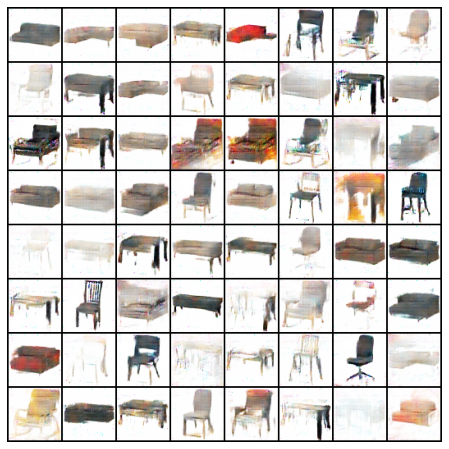

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())